# From `zipline` to `pyfolio`

## `pyfolio` Features

* State-of-the-art portfolio and risk analytics
* http://quantopian.github.io/pyfolio/
* Open source and free: Apache v2 license
* Can be used:
   - stand alone
   - with Zipline
   - on Quantopian
   - with PyThalesians

## Installation

* Use Anaconda to get a Python system with the full PyData ecosystem.
* `pip install pyfolio`

## Zipline + pyfolio

* Open-source backtester by Quantopian Inc.
* Powers Quantopian.com
* Various models for transaction costs and slippage.

In [1]:
from pathlib import Path
import warnings
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import *
from pyfolio.timeseries import *
from pyfolio.tears import *

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [4]:
with pd.HDFStore('../01_trading_zipline/backtests.h5') as store:
    backtest = store['backtest']
backtest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 to 2017-12-29
Data columns (total 39 columns):
algo_volatility            754 non-null float64
algorithm_period_return    755 non-null float64
alpha                      754 non-null float64
benchmark_period_return    755 non-null float64
benchmark_volatility       754 non-null float64
beta                       754 non-null float64
capital_used               755 non-null float64
ending_cash                755 non-null float64
ending_exposure            755 non-null float64
ending_value               755 non-null float64
excess_return              755 non-null float64
factor_data                755 non-null object
gross_leverage             755 non-null float64
long_exposure              755 non-null float64
long_value                 755 non-null float64
longs_count                755 non-null int64
max_drawdown               755 non-null float64
max_leverage               755 non-null float64
net_leverage   

## Converting data from zipline to pyfolio

In [5]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

In [6]:
returns.head().append(returns.tail())

2015-01-02 00:00:00+00:00    0.000000
2015-01-05 00:00:00+00:00   -0.000001
2015-01-06 00:00:00+00:00   -0.001582
2015-01-07 00:00:00+00:00    0.000337
2015-01-08 00:00:00+00:00    0.000368
2017-12-22 00:00:00+00:00   -0.000249
2017-12-26 00:00:00+00:00   -0.003149
2017-12-27 00:00:00+00:00    0.003261
2017-12-28 00:00:00+00:00    0.001681
2017-12-29 00:00:00+00:00   -0.000368
Name: returns, dtype: float64

In [7]:
positions.columns = [c.symbol for c in positions.columns[:-1]] + ['cash']
positions.index = positions.index.normalize()
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2015-01-05 to 2017-12-29
Columns: 529 entries, AAL to cash
dtypes: float64(529)
memory usage: 3.0 MB


In [8]:
transactions.symbol = transactions.symbol.apply(lambda x: x.symbol)

In [9]:
transactions.head().append(transactions.tail())

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2015-01-05 21:00:00+00:00,11334,None,2015-01-05 21:00:00+00:00,5e563286a9014b6a91debaf50674ba68,13.970001,Equity(2076 [OCN]),OCN,-158335.989895
2015-01-05 21:00:00+00:00,4235,None,2015-01-05 21:00:00+00:00,271960b8933c42f8bf4afa484dc0b210,93.730000,Equity(2195 [PEP]),PEP,-396946.551716
2015-01-05 21:00:00+00:00,-2256,None,2015-01-05 21:00:00+00:00,f890da10d44f41db8caba6f7877aab51,92.049994,Equity(391 [BLUE]),BLUE,207664.787026
2015-01-06 21:00:00+00:00,15279,None,2015-01-06 21:00:00+00:00,5e563286a9014b6a91debaf50674ba68,13.480000,Equity(2076 [OCN]),OCN,-205960.925692
2015-01-06 21:00:00+00:00,-2127,None,2015-01-06 21:00:00+00:00,f890da10d44f41db8caba6f7877aab51,95.239997,Equity(391 [BLUE]),BLUE,202575.474323
2017-12-29 21:00:00+00:00,-1474,None,2017-12-29 21:00:00+00:00,aa2ae7e425ef4e91abeffbcf08f2191e,66.599997,Equity(2348 [QRVO]),QRVO,98168.395700
2017-12-29 21:00:00+00:00,-1476,None,2017-12-29 21:00:00+00:00,6a975a2df5b0404c92232f441ac129d0,42.569997,Equity(1743 [LYV]),LYV,62833.316075
2017-12-29 21:00:00+00:00,64,None,2017-12-29 21:00:00+00:00,4b39d9b302354a908e2e05d419683ba1,69.690000,Equity(946 [EMR]),EMR,-4460.160000
2017-12-29 21:00:00+00:00,-3183,None,2017-12-29 21:00:00+00:00,9f19d150f1b04490b39f8311fbb58679,21.170000,Equity(829 [DISCK]),DISCK,67384.108543
2017-12-29 21:00:00+00:00,-89,None,2017-12-29 21:00:00+00:00,5f1420c1ab52404cb5ca583784397ffb,96.020000,Equity(859 [DRI]),DRI,8545.780000


In [10]:
HDF_PATH = Path('..', '00_data', 'assets.h5')

### Sector Map

In [11]:
assets = positions.columns[:-1]
with pd.HDFStore(HDF_PATH) as store:
    df = store.get('us_equities/stocks')['sector'].dropna()
    df = df[~df.index.duplicated()]
sector_map = df.reindex(assets).fillna('Unknown').to_dict()

### Benchmark

In [12]:
with pd.HDFStore(HDF_PATH) as store:
    benchmark_rets = store['sp500/prices'].close.pct_change()
benchmark_rets.name = 'S&P500'
benchmark_rets = benchmark_rets.tz_localize('UTC').filter(returns.index)
benchmark_rets.tail()

date
2017-12-22 00:00:00+00:00   -0.000458
2017-12-26 00:00:00+00:00   -0.001058
2017-12-27 00:00:00+00:00    0.000791
2017-12-28 00:00:00+00:00    0.001834
2017-12-29 00:00:00+00:00   -0.005183
Name: S&P500, dtype: float64

## Returns Analysis

In [20]:
show_perf_stats(returns=returns, 
                factor_returns=benchmark_rets, 
                positions=positions, 
                transactions=transactions, 
                live_start_date=oos_date)

In-sample months: 24
Out-of-sample months: 11


,All,In-sample,Out-of-sample
Annual return,1.8%,0.6%,4.2%
Cumulative returns,5.4%,1.1%,4.2%
Annual volatility,5.8%,6.3%,4.6%
Sharpe ratio,0.33,0.12,0.92
Calmar ratio,0.17,0.06,1.28
Stability,0.49,0.04,0.75
Max drawdown,-10.1%,-10.1%,-3.3%
Omega ratio,1.06,1.02,1.18
Sortino ratio,0.48,0.18,1.37
Skew,0.34,0.40,0.09


### Rolling Returns OOS

In [16]:
oos_date = '2017-01-01'

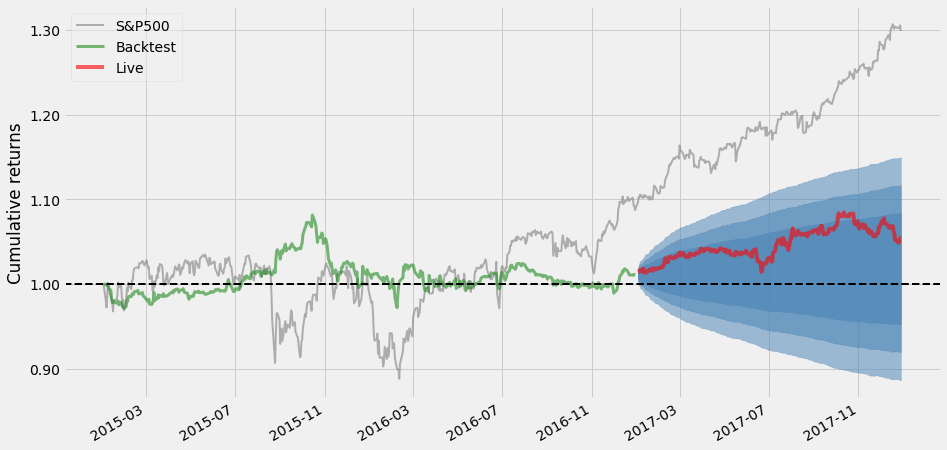

In [17]:
plot_rolling_returns(returns=returns, factor_returns=benchmark_rets, live_start_date=oos_date, cone_std=(1.0, 1.5, 2.0))
plt.gcf().set_size_inches(14, 8)

### Rolling Sharpe

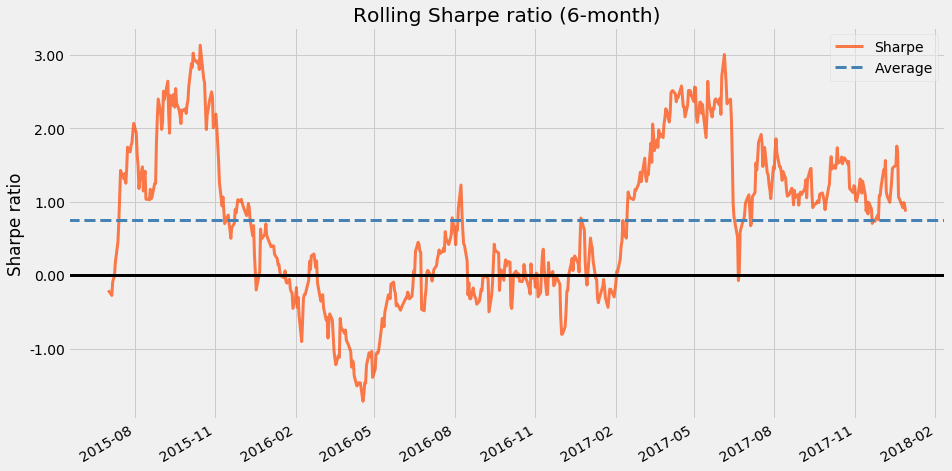

In [96]:
plot_rolling_sharpe(returns=returns)
plt.gcf().set_size_inches(14, 8);

### Rolling Beta

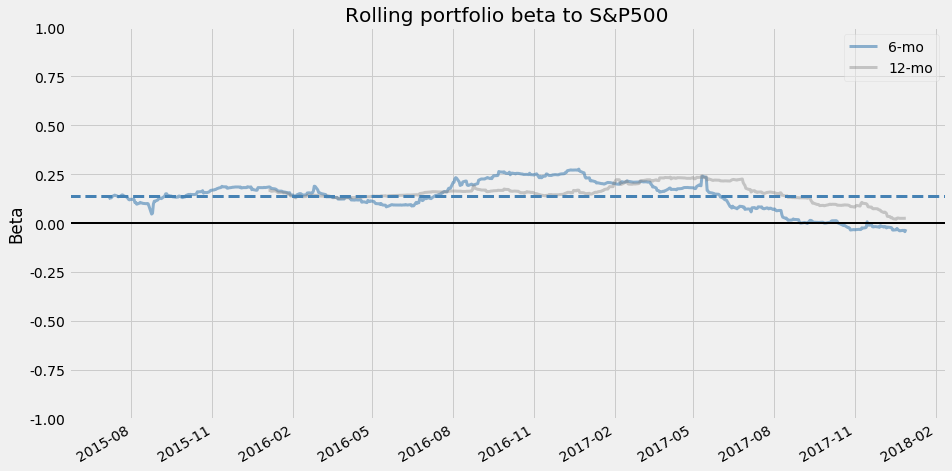

In [99]:
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets)
plt.gcf().set_size_inches(14, 8);

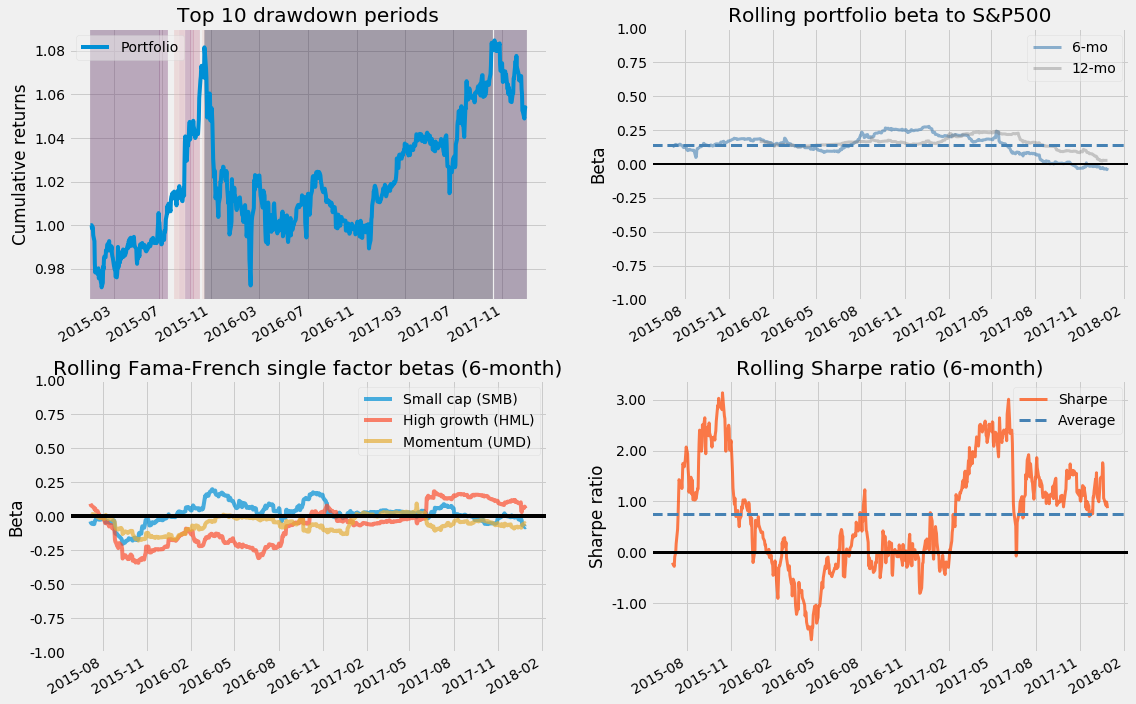

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = ax.flatten()

plot_drawdown_periods(returns=returns, ax=axes[0])
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[1])
plot_rolling_fama_french(returns=returns, ax=axes[2])
plot_rolling_sharpe(returns=returns)
plt.tight_layout();

### Returns Tear Sheet

Entire data start date: 2015-01-05
Entire data end date: 2017-12-29
In-sample months: 23
Out-of-sample months: 11


,All,In-sample,Out-of-sample
Annual return,1.8%,0.6%,4.2%
Cumulative returns,5.4%,1.1%,4.2%
Annual volatility,5.8%,6.3%,4.6%
Sharpe ratio,0.33,0.12,0.92
Calmar ratio,0.17,0.06,1.28
Stability,0.49,0.04,0.75
Max drawdown,-10.1%,-10.1%,-3.3%
Omega ratio,1.06,1.02,1.18
Sortino ratio,0.48,0.18,1.37
Skew,0.34,0.40,0.09


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.09,2015-10-15,2016-02-08,2017-10-05,516
1,3.30,2017-10-12,2017-12-26,NaT,NaN
2,2.85,2015-01-05,2015-01-30,2015-06-22,121
3,1.43,2015-06-22,2015-06-29,2015-07-14,17
4,1.07,2015-08-28,2015-09-01,2015-09-08,8


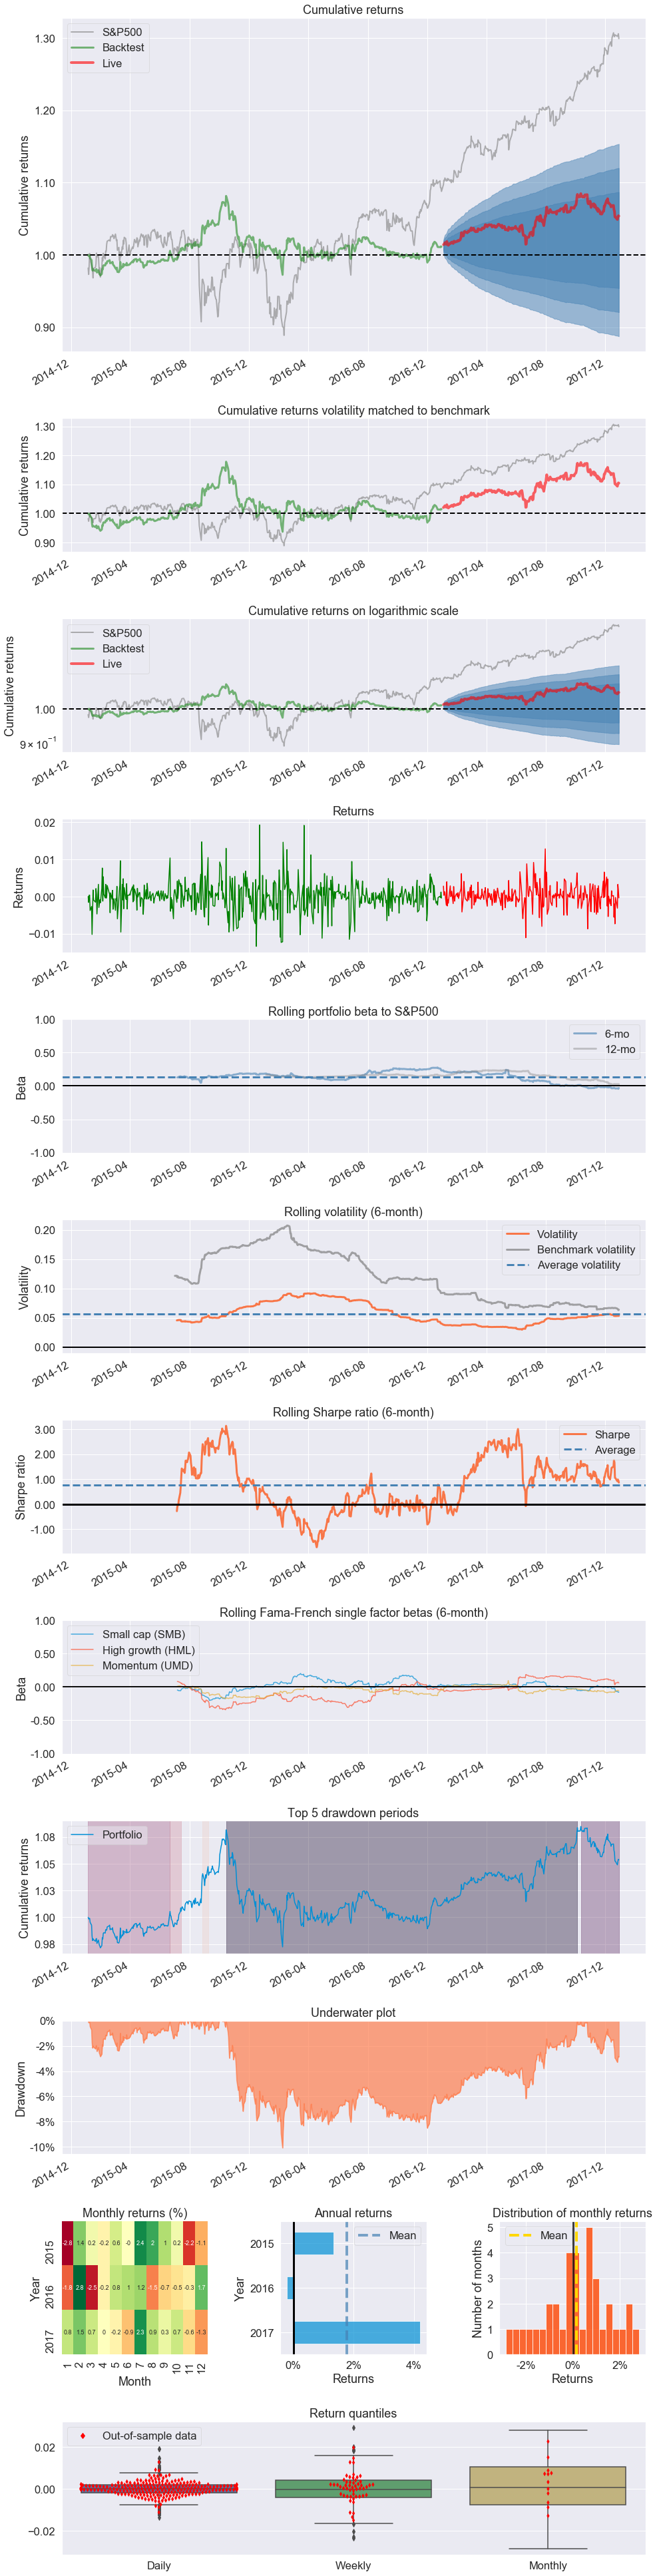

In [97]:
fig = create_returns_tear_sheet(returns=returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark_rets,
                          live_start_date=oos_date,
                          return_fig=True)
fig.savefig('test_fig')

## Modeling Event Risk

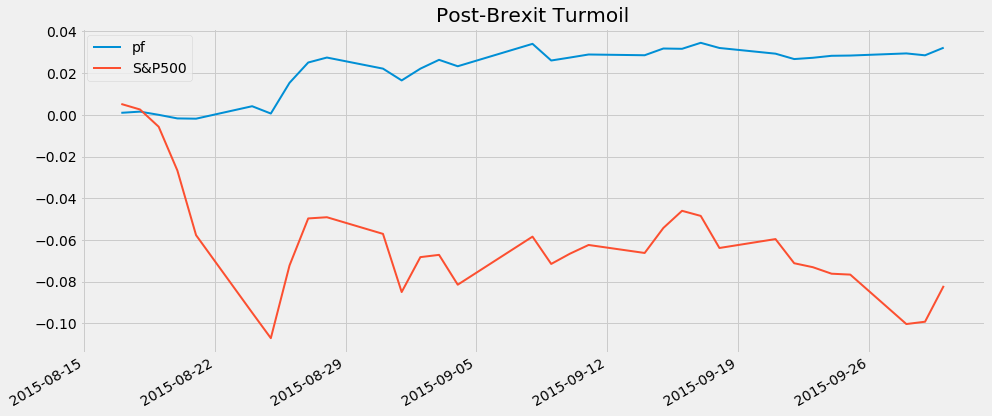

In [33]:
interesting_times = extract_interesting_date_ranges(returns=returns)
(interesting_times['Fall2015']
 .to_frame('pf').join(benchmark_rets)
 .add(1).cumprod().sub(1)
 .plot(lw=2, figsize=(14, 6), title='Post-Brexit Turmoil'))
plt.tight_layout();

## Full Tear Sheet

Entire data start date: 2015-01-05
Entire data end date: 2017-12-29
In-sample months: 23
Out-of-sample months: 11


,All,In-sample,Out-of-sample
Annual return,1.7%,0.5%,4.2%
Cumulative returns,5.3%,1.1%,4.2%
Annual volatility,5.8%,6.3%,4.6%
Sharpe ratio,0.33,0.12,0.92
Calmar ratio,0.17,0.05,1.27
Stability,0.49,0.03,0.75
Max drawdown,-10.1%,-10.1%,-3.3%
Omega ratio,1.06,1.02,1.18
Sortino ratio,0.48,0.17,1.36
Skew,0.34,0.40,0.09


/home/stefan/.pyenv/versions/3.6.4/envs/at-3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.09,2015-10-15,2016-02-08,2017-10-05,516
1,3.31,2017-10-12,2017-12-26,NaT,NaN
2,2.85,2015-01-05,2015-01-30,2015-06-22,121
3,1.43,2015-06-22,2015-06-29,2015-07-14,17
4,1.07,2015-08-28,2015-09-01,2015-09-08,8


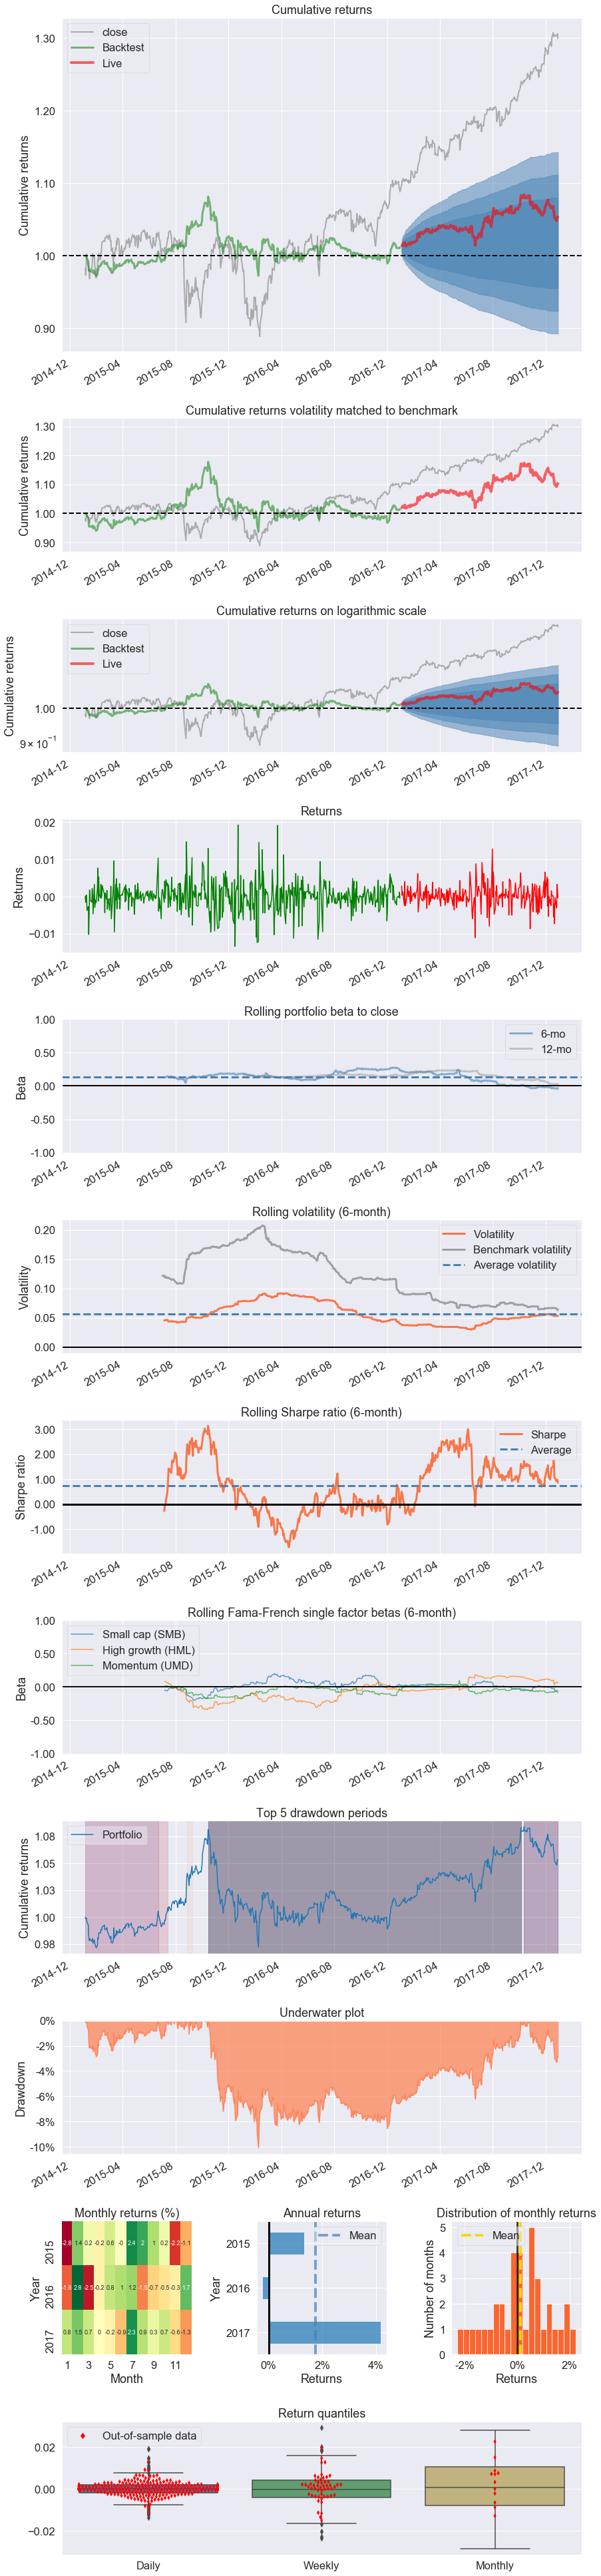

Stress Events,mean,min,max
Fall2015,0.10%,-0.77%,1.47%
New Normal,0.01%,-1.34%,1.93%


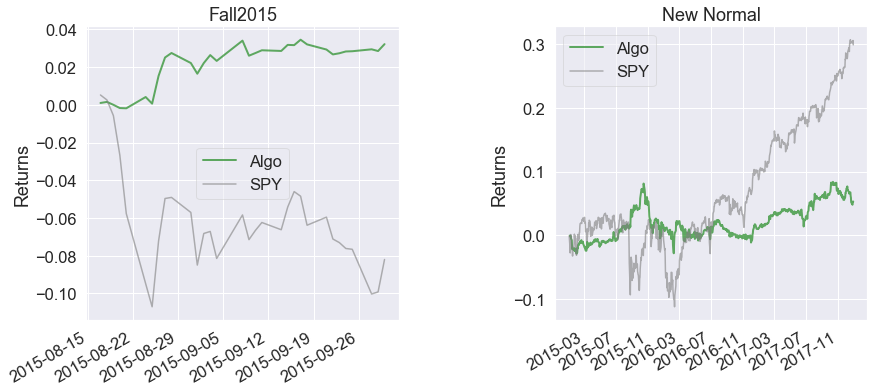

Top 10 long positions of all time,max
VRX,5.37%
LL,5.09%
XPO,4.99%
CLVS,4.95%
SUNE,4.92%
P,4.91%
POM,4.83%
ICPT,4.82%
FOSL,4.67%
VRTX,4.61%


Top 10 short positions of all time,max
WTW,-6.06%
SCTY,-5.59%
SWN,-5.41%
CLVS,-4.96%
RRC,-4.82%
JCP,-4.64%
CHK,-4.58%
COG,-4.58%
BLUE,-4.56%
SE,-4.54%


Top 10 positions of all time,max
WTW,6.06%
SCTY,5.59%
SWN,5.41%
VRX,5.37%
LL,5.09%
XPO,4.99%
CLVS,4.96%
SUNE,4.92%
P,4.91%
POM,4.83%


All positions ever held,max
WTW,6.06%
SCTY,5.59%
SWN,5.41%
VRX,5.37%
LL,5.09%
XPO,4.99%
CLVS,4.96%
SUNE,4.92%
P,4.91%
POM,4.83%


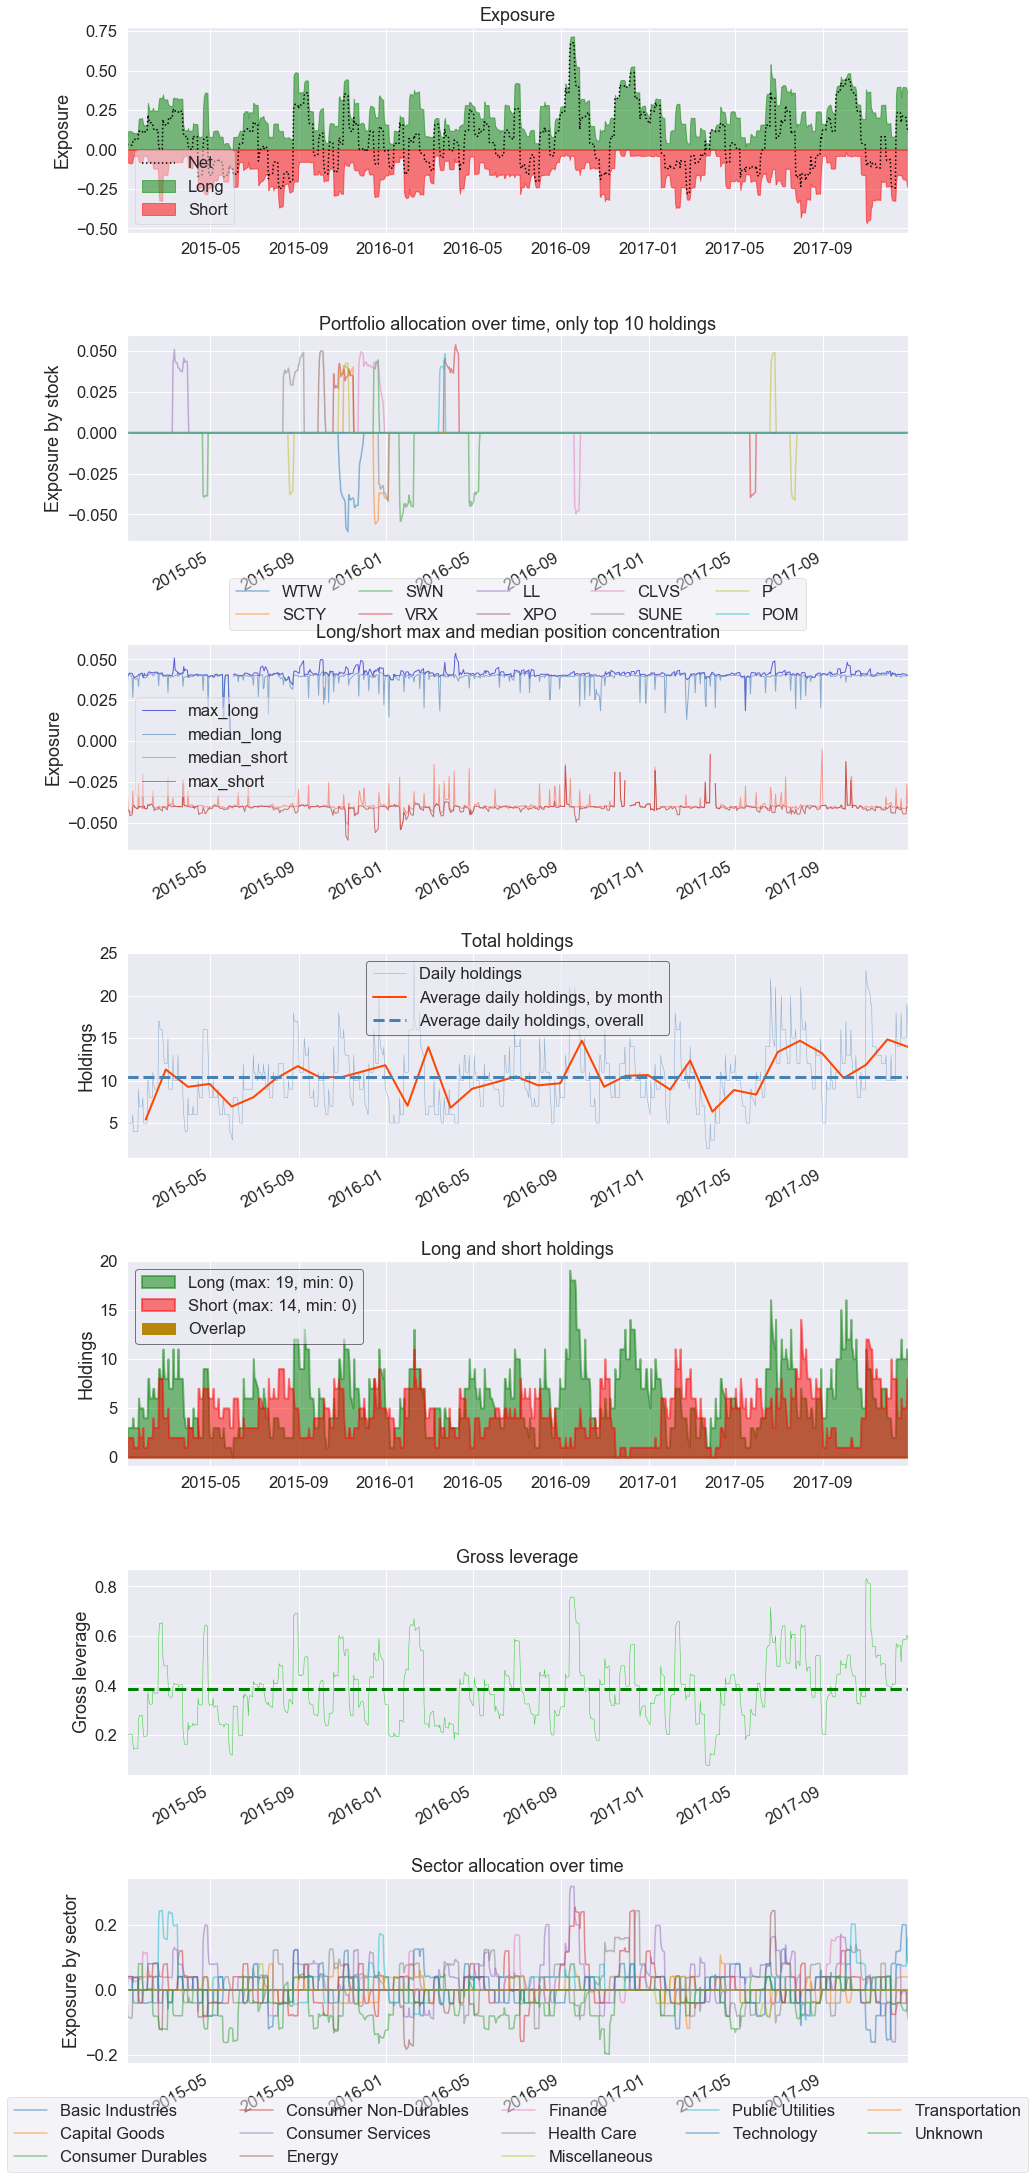

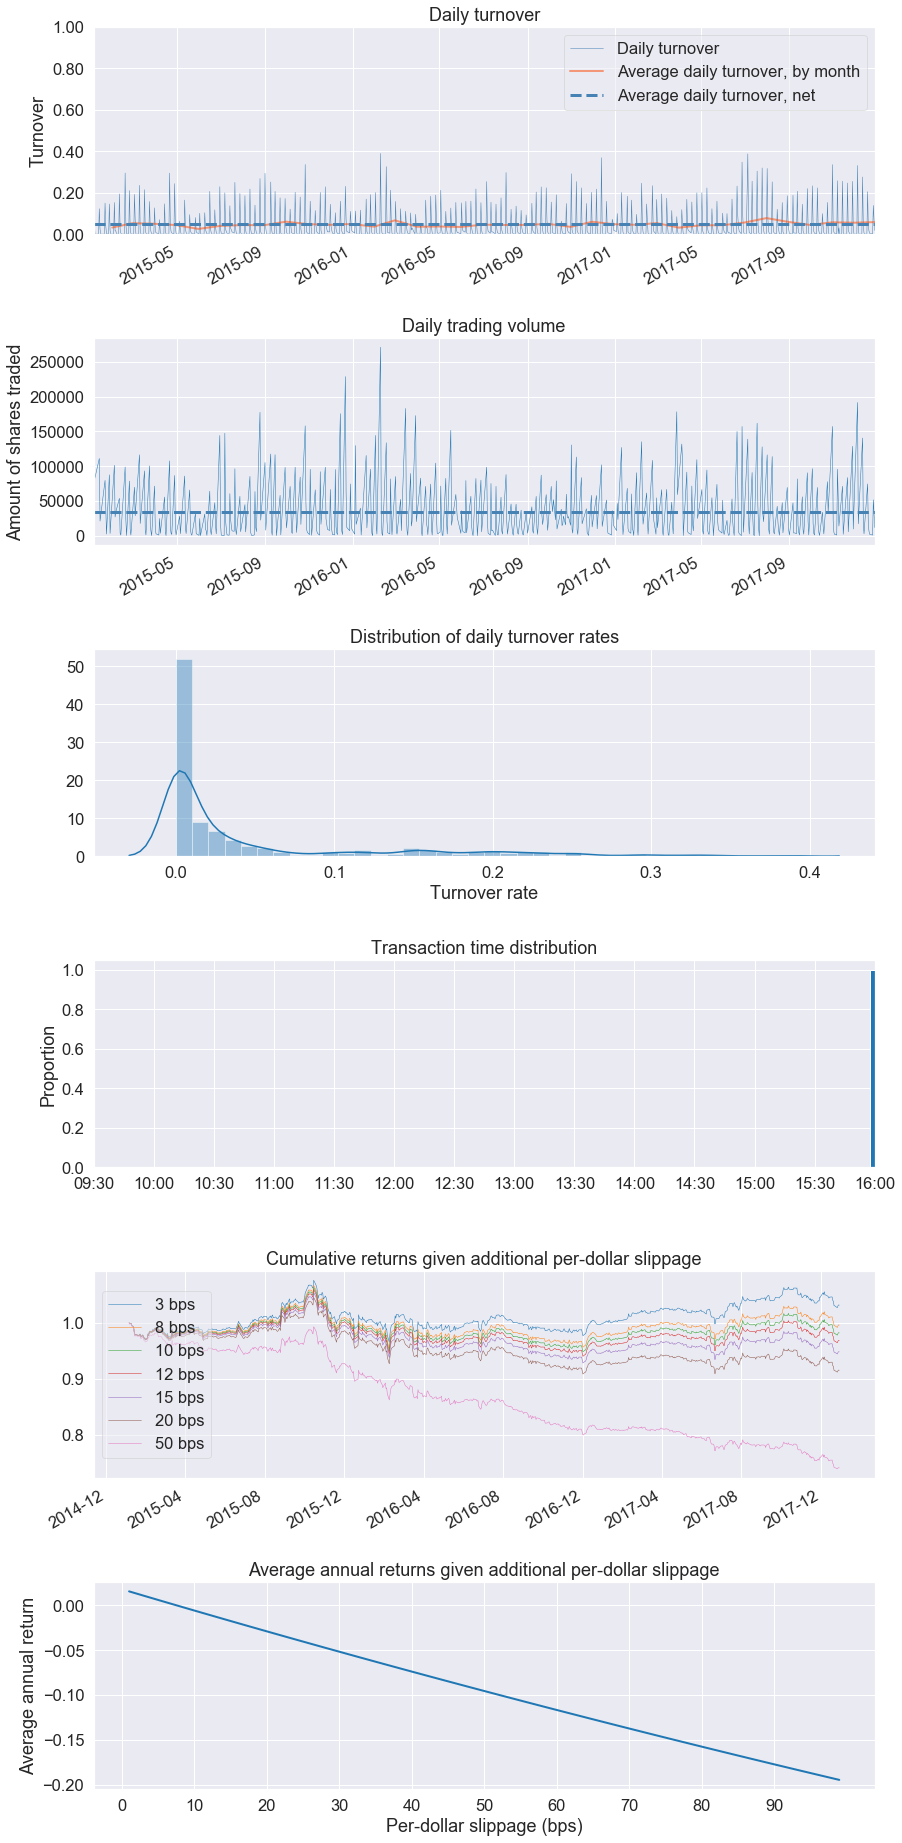

In [76]:
create_full_tear_sheet(returns,
                       positions=positions,
                       transactions=transactions,
                       live_start_date=oos_date,
                       slippage=0.1,
                       benchmark_rets=benchmark_rets,
                       sector_mappings=sector_map)

## Bayesian analysis in pyfolio

* Sneak-peek into ongoing research.
* Focus is on comparing backtest (in-sample) and forward-test (out-of-sample; OOS).
* Sophisticated statistical modeling taking uncertainty into account.
* Uses T-distribution to model returns (instead of normal).
* Relies on [PyMC3](http://pymc-devs.github.io/pymc3/).

In [27]:
create_bayesian_tear_sheet(returns, live_start_date=oos_date)

NotImplementedError: Bayesian tear sheet requirements not found.
Run 'pip install pyfolio[bayesian]' to install bayesian requirements.